# Benchmarking the Permanent

This tutorial shows how to use the permanent function using The Walrus, which calculates the permanent using Ryser's algorithm

### The Permanent
The permanent of an $n$-by-$n$ matrix A = $a_{i,j}$ is defined as

$\text{perm}(A)=\sum_{\sigma\in S_n}\prod_{i=1}^n a_{i,\sigma(i)}.$

The sum here extends over all elements $\sigma$ of the symmetric group $S_n$; i.e. over all permutations of the numbers $1, 2, \ldots, n$. ([see Wikipedia](https://en.wikipedia.org/wiki/Permanent)).

The function `thewalrus.perm` implements [Ryser's algorithm](https://en.wikipedia.org/wiki/Computing_the_permanent#Ryser_formula) to calculate the permanent of an arbitrary matrix using [Gray code](https://en.wikipedia.org/wiki/Gray_code) ordering.

## Using the library

Once installed or compiled, one imports the library in the usual way:

In [1]:
from thewalrus import perm

To use it  we need to pass square numpy arrays thus we also import NumPy:

In [2]:
import numpy as np
import time

The library provides functions to compute permanents of real and complex matrices. The functions take as arguments the matrix; the number of threads to be used to do the computation are determined using OpenMP.

In [3]:
size = 20
matrix = np.ones([size,size])
perm(matrix)

2.43290200817664e+18

In [4]:
size = 20
matrix = np.ones([size,size], dtype=np.complex128)
perm(matrix)

2.43290200817664e+18

Not surprisingly, the permanent of a matrix containing only ones equals the factorial of the dimension of the matrix, in our case $20!$.

In [5]:
from math import factorial
factorial(20)

2432902008176640000

### Benchmarking the performance of the code

For sizes $n=1,28$ we will generate random unitary matrices and measure the (average) amount of time it takes to calculate their permanent. The number of samples for each will be geometrically distirbuted with a 1000 samples for size $n=1$ and 10 samples for $n=28$. The unitaries will be random Haar distributed.

In [6]:
a0 = 1000.
anm1 = 10.
n = 28
r = (anm1/a0)**(1./(n-1))
nreps = [(int)(a0*(r**((i)))) for i in range(n)]

In [7]:
nreps

[1000,
 843,
 710,
 599,
 505,
 426,
 359,
 303,
 255,
 215,
 181,
 153,
 129,
 108,
 91,
 77,
 65,
 55,
 46,
 39,
 33,
 27,
 23,
 19,
 16,
 14,
 11,
 10]

The following function generates random Haar unitaries of dimensions $n$

In [8]:
from scipy import diagonal, randn
from scipy.linalg import qr
def haar_measure(n):
    '''A Random matrix distributed with Haar measure
    See https://arxiv.org/abs/math-ph/0609050
    How to generate random matrices from the classical compact groups
    by Francesco Mezzadri '''
    z = (randn(n,n) + 1j*randn(n,n))/np.sqrt(2.0)
    q,r = qr(z)
    d = diagonal(r)
    ph = d/np.abs(d)
    q = np.multiply(q,ph,q)
    return q

Now let's bench mark the scaling of the calculation with the matrix size:

In [9]:
times = np.empty(n)
for ind, reps in enumerate(nreps):
    #print(ind+1,reps)
    start = time.time()
    for i in range(reps):
        size = ind+1
        nth = 1
        matrix = haar_measure(size)
        res = perm(matrix)
    end = time.time()
    times[ind] = (end - start)/reps
    print(ind+1, times[ind])

1 0.00028934645652770995
2 0.0001495122061081204
3 0.00015489853603739133
4 0.0004637452318194713
5 0.00017665730844629873
6 0.0006603159255265071
7 0.0006937515768832151
8 0.0008643358060629061
9 0.0004252480525596469
10 0.0008683936540470567
11 0.0006751460923674357
12 0.001460242115594203
13 0.002330223719278971
14 0.00457644021069562
15 0.010608830294766268
16 0.01871370959591556
17 0.04012102713951698
18 0.08530152927745473
19 0.17479530106420102
20 0.3602719612610646
21 0.7553631681384463
22 1.603381006805985
23 3.432816049327021
24 7.144709775322362
25 14.937034338712692
26 31.058412892477854
27 64.35744528336959
28 136.51278076171874


We can now plot the (average) time it takes to calculate the permanent vs. the size of the matrix:

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

Text(0, 0.5, 'Time in seconds for 4 threads')

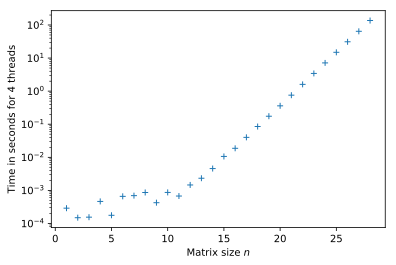

In [11]:
plt.semilogy(np.arange(1,n+1),times,"+")
plt.xlabel(r"Matrix size $n$")
plt.ylabel(r"Time in seconds for 4 threads")

We can also fit to the theoretical scaling of $ c n 2^n$ and use it to extrapolate for larger sizes:

In [12]:
def fit(n,c):
    return c*n*2**n

In [13]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit, np.arange(1,n+1)[15:-1],times[15:-1])

The scaling prefactor is 

In [14]:
popt[0]

1.776816058334955e-08

And we can use it to extrapolate the time it takes to calculate permanents of bigger dimensions

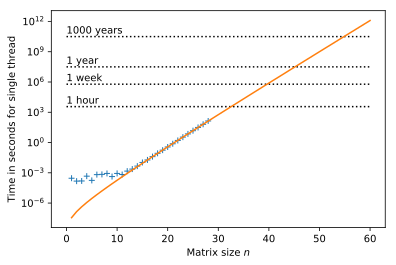

In [15]:
flags = [3600,3600*24*7, 3600*24*365, 3600*24*365*1000]
labels = ["1 hour", "1 week", "1 year", "1000 years"]
plt.semilogy(np.arange(1,n+1), times, "+", np.arange(1,61), fit(np.arange(1,61),popt[0]))
plt.xlabel(r"Matrix size $n$")
plt.ylabel(r"Time in seconds for single thread")
plt.hlines(flags,0,60,label="1 hr",linestyles=u'dotted')
for i in range(len(flags)):
    plt.text(0,2*flags[i], labels[i])

The specs of the computer on which this benchmark was performed are:

In [16]:
!cat /proc/cpuinfo|head -19 

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 21
model		: 101
model name	: AMD A12-9800 RADEON R7, 12 COMPUTE CORES 4C+8G
stepping	: 1
microcode	: 0x6006118
cpu MHz		: 2709.605
cache size	: 1024 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 16
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
